In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Carregar o dataset
df_vendas = pd.read_csv("./dataset/sales_data.csv")

In [3]:
# Inspecionar a estrutura do dataframe
df_vendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tempo_de_experiencia  100 non-null    int64  
 1   numero_de_vendas      100 non-null    int64  
 2   fator_sazonal         100 non-null    int64  
 3   receita_em_reais      100 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 3.3 KB


### EDA

In [4]:
# Visualizar as primeiras linhas
df_vendas.head()

,tempo_de_experiencia,numero_de_vendas,fator_sazonal,receita_em_reais
0,36,21,5,2639.886941
1,74,44,10,4707.322227
2,38,44,4,5910.035131
3,52,62,6,6130.742546
4,97,56,2,7516.457681


In [5]:
# Detectar valores ausentes
df_vendas.isna().sum()

tempo_de_experiencia    0
numero_de_vendas        0
fator_sazonal           0
receita_em_reais        0
dtype: int64

In [6]:
# Medidas estatísticas do dataframe
df_vendas.describe()

,tempo_de_experiencia,numero_de_vendas,fator_sazonal,receita_em_reais
count,100.000000,100.000000,100.000000,100.000000
mean,64.490000,54.490000,5.820000,5112.941924
std,32.397935,25.307201,2.836914,2544.731052
min,1.000000,10.000000,1.000000,1133.363948
25%,38.750000,37.500000,4.000000,2800.660516
50%,64.500000,52.500000,5.000000,4953.770034
75%,93.000000,70.500000,8.000000,7079.500163
max,119.000000,100.000000,10.000000,9941.016458


<Axes: xlabel='tempo_de_experiencia'>

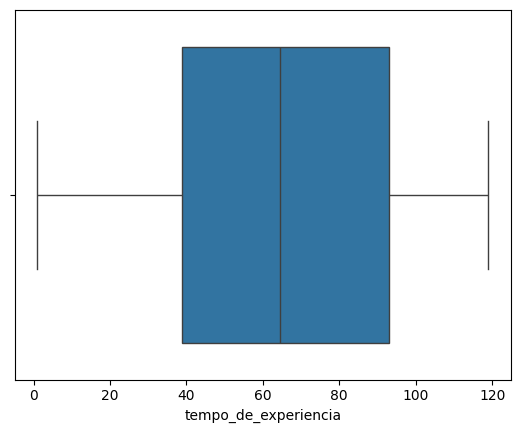

In [7]:
# Detectar outliers - tempo_de_experiencia
sns.boxplot(data=df_vendas, x='tempo_de_experiencia')

<Axes: xlabel='numero_de_vendas'>

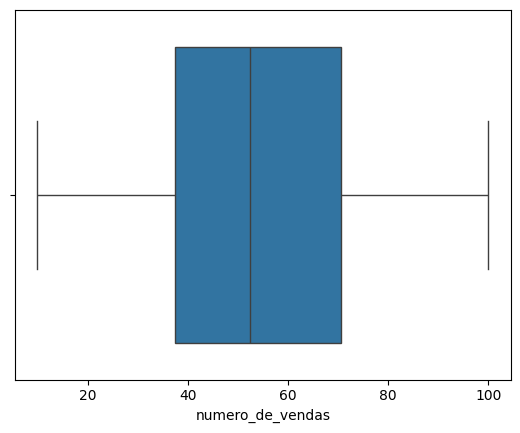

In [8]:
# Detectar outliers - numero_de_vendas
sns.boxplot(data=df_vendas, x='numero_de_vendas')

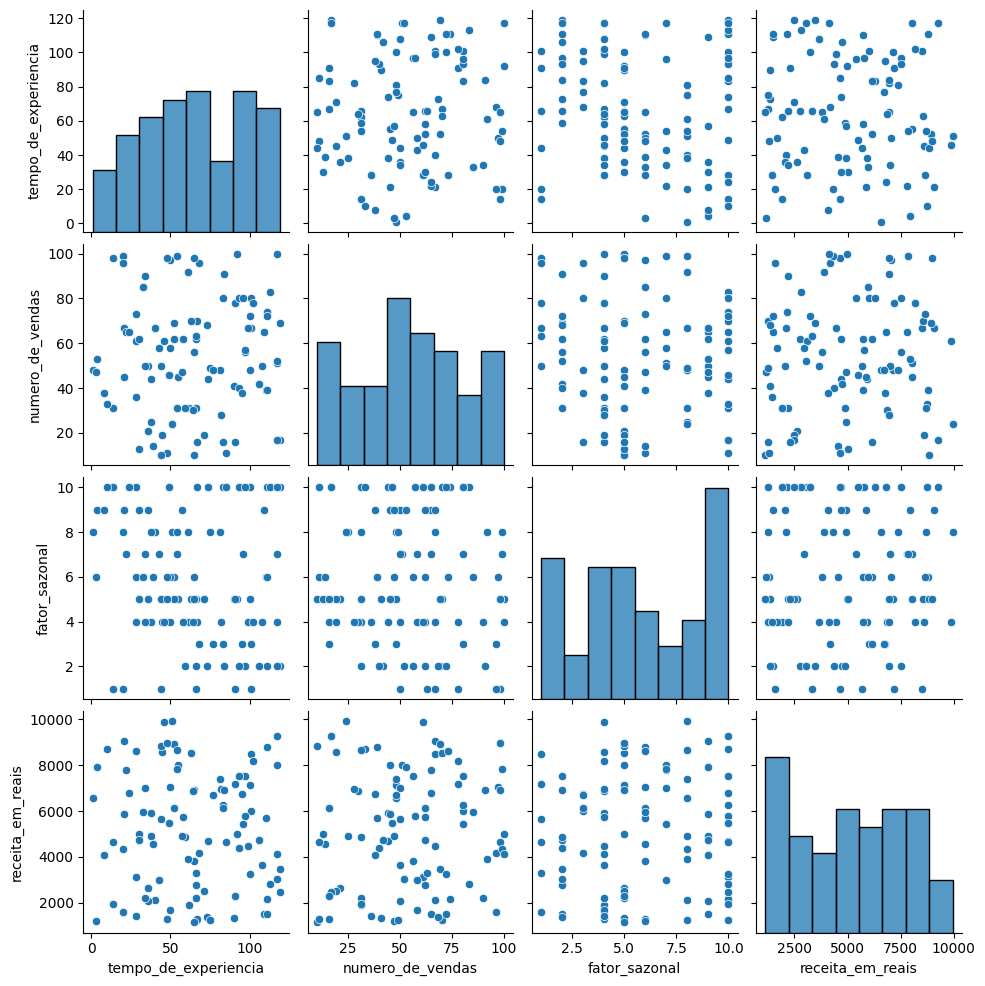

In [9]:
# Cruzamento das variáveis com a variável target - receita_em_reais
sns.pairplot(df_vendas)

<Axes: >

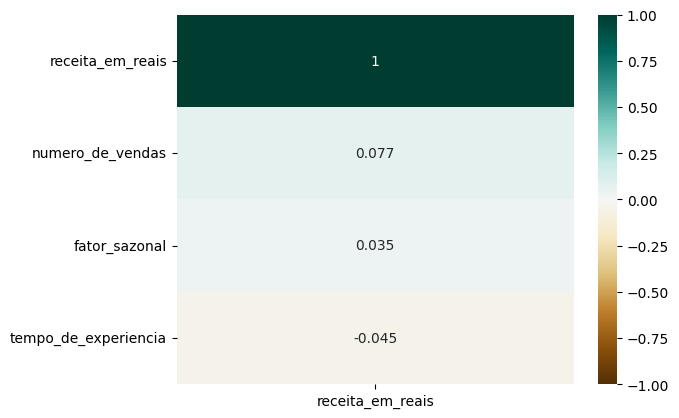

In [10]:
# Formato de Ranking
sns.heatmap(df_vendas.corr('spearman')[['receita_em_reais']]
  .sort_values(by='receita_em_reais', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

### Preparação dos dados para treinamento

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [12]:
X = df_vendas[['tempo_de_experiencia', 'numero_de_vendas']]
y = df_vendas['receita_em_reais']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=51)

### Treinamento do Modelo Linear

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [15]:
pipeline_lr = Pipeline([
  ('scaler', StandardScaler()),
  ('model', LinearRegression())
])

In [16]:
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [17]:
y_pred = pipeline_lr.predict(X_test)

In [18]:
mean_squared_error(y_test, y_pred)

7083471.122061013

In [19]:
r2_score(y_test, y_pred)

-0.21668782087524807

### Análise de Resíduos - Regressão Linear

In [20]:
from scipy.stats import zscore
import pingouin as pg
from scipy.stats import shapiro

In [21]:
residuos = y_test - y_pred

In [22]:
residuos_std = zscore(residuos)

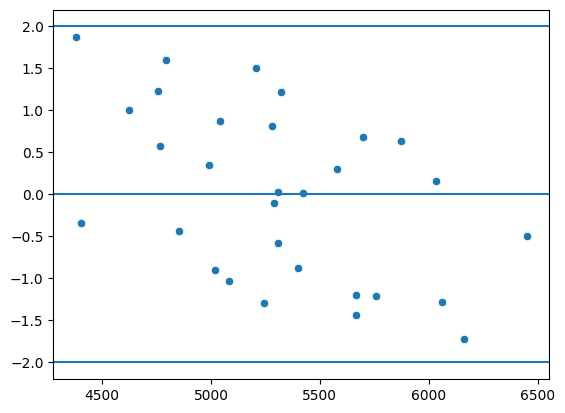

In [23]:
sns.scatterplot(x=y_pred, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=2)
plt.axhline(y=-2)

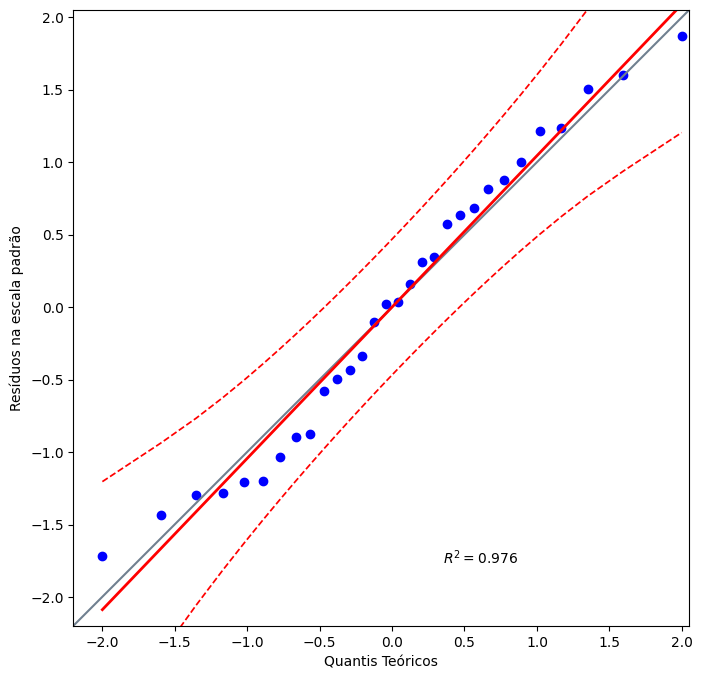

In [24]:
plt.figure(figsize=(14,8))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Resíduos na escala padrão')
plt.show()

In [25]:
stat_shapiro, p_value_shapiro = shapiro(residuos)
print(f"Estat. Teste {stat_shapiro} e P-Value {p_value_shapiro}")

Estat. Teste 0.9631437773441942 e P-Value 0.3717447096726737


### Treinar Modelo de Regressão Polinomial

In [26]:
from sklearn.preprocessing import PolynomialFeatures

In [27]:
# Preparar os dados incluindo fator_sazonal
X = df_vendas.drop(columns=['receita_em_reais'])
y = df_vendas['receita_em_reais']

In [28]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y, test_size=0.3, random_state=51)

In [29]:
pipeline_poly = Pipeline([
  ('scaler', StandardScaler()),
  ('poly', PolynomialFeatures(degree=3)),
  ('model', LinearRegression())
])

In [30]:
pipeline_poly.fit(X_train_p, y_train_p)

Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(degree=3)),
                ('model', LinearRegression())])

In [31]:
y_pred_p = pipeline_poly.predict(X_test_p)

In [32]:
mean_squared_error(y_test_p, y_pred_p)

10050194.755097352

In [33]:
r2_score(y_test, y_pred)

-0.21668782087524807

### Análise de Resíduos - Regressão Polinomial

In [34]:
from scipy.stats import zscore
import pingouin as pg
from scipy.stats import shapiro

In [35]:
residuos = y_test_p - y_pred_p

In [36]:
residuos_std = zscore(residuos)

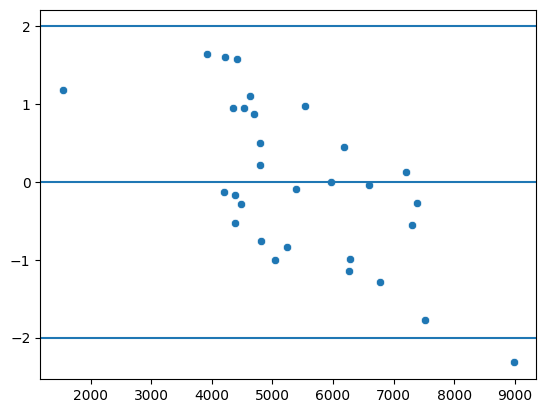

In [37]:
sns.scatterplot(x=y_pred_p, y=residuos_std)
plt.axhline(y=0)
plt.axhline(y=2)
plt.axhline(y=-2)

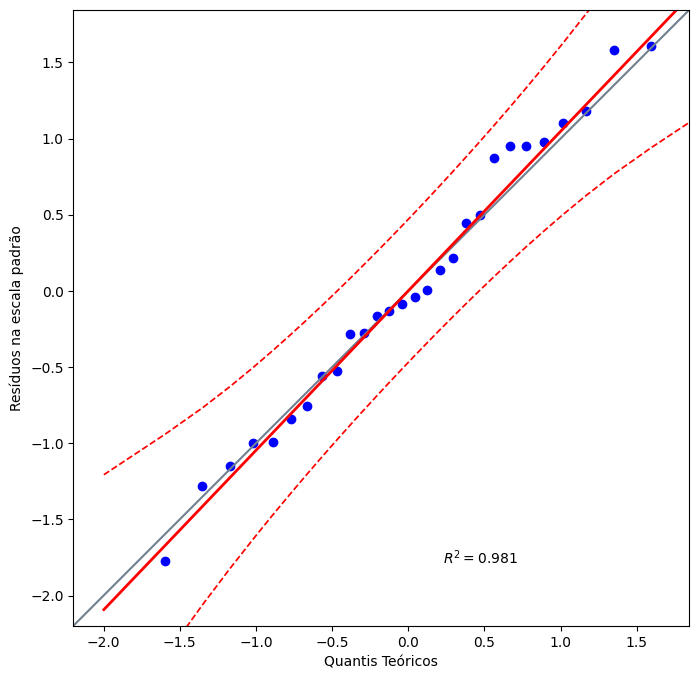

In [38]:
plt.figure(figsize=(14,8))
pg.qqplot(residuos_std, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Resíduos na escala padrão')
plt.show()

In [39]:
stat_shapiro, p_value_shapiro = shapiro(residuos)
print(f"Estat. Teste {stat_shapiro} e P-Value {p_value_shapiro}")

Estat. Teste 0.9748678630096161 e P-Value 0.6788352729624074


### Comparação Gráfica entre os dois modelos

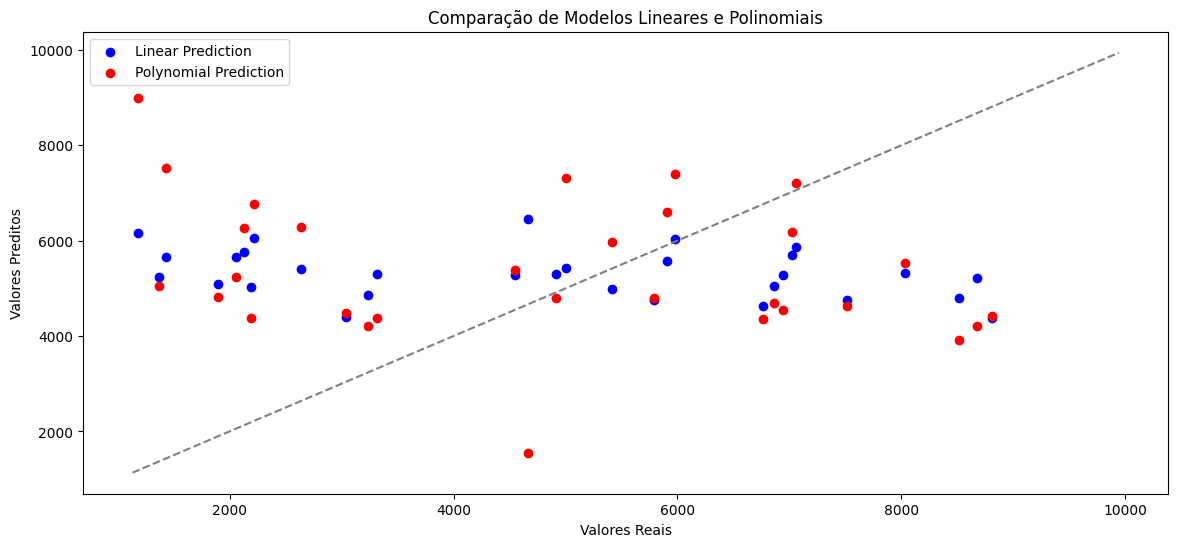

In [40]:
# Comparação Gráfica
plt.figure(figsize=(14, 6))
plt.scatter(y_test, y_pred, color='blue', label='Linear Prediction')
plt.scatter(y_test, y_pred_p, color='red', label='Polynomial Prediction')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Comparação de Modelos Lineares e Polinomiais')
plt.legend()
plt.show()

### Predição Individual

In [41]:
input_features = {
  'tempo_de_experiencia': [36],
  'numero_de_vendas': [21],
  'fator_sazonal': [5]
}

pred_df = pd.DataFrame(input_features, index=[1])

In [42]:
pipeline_poly.predict(pred_df)

array([6286.04255285])

In [43]:
input_features = {
  'tempo_de_experiencia': [36],
  'numero_de_vendas': [21],
}

pred_df = pd.DataFrame(input_features, index=[1])

In [44]:
pipeline_lr.predict(pred_df)

array([5401.15980558])

In [45]:
import joblib

In [46]:
joblib.dump(pipeline_poly, './model.pkl')

['./model.pkl']